# Beachwatch

This notebook examines the bacteria count data for the San Diego coastline, from the Beachwatch program. To analyze beachwatch data, we'll use the data package that is stored on the Library's data repository.



In [1]:
import matplotlib.pyplot as plt 
import metapack as mp
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd

# Well just jump right into open the dataset. See  '0 Beachwatch Exploration' for details about
# opening packages. 
pkg = mp.open_package('http://library.metatab.org/ceden.waterboards.ca.gov-beachwatch-sandiego-2.zip')
df = pkg.resource('beachwatch-sd').read_csv(parse_dates=True)

# It looks like the prefix of the station code groups stations, maybe into watersheds. 
df['stationgroup'] = df.stationcode.str[:2]

# The results has a large range, so log transformation makes them easier to visualize.
df['log_result'] = df.result.apply(np.log10)

# Just focus on one type of analyte. 
dfs = df[(df.analyte == 'Coliform, Total') & (df.unit == 'MPN/100 mL')]
len(dfs)



47515

# Log or Not?

Bacteria grows expoentionally, so small changes in time or the environment can have huge changes in the number of bacteria. For measurements with a large range, analysis may better be done on the log-transformed values. 

The first of these two plots is bacteria count with the raw ``results`` column. The second uses the log transformed results from ``log_results``


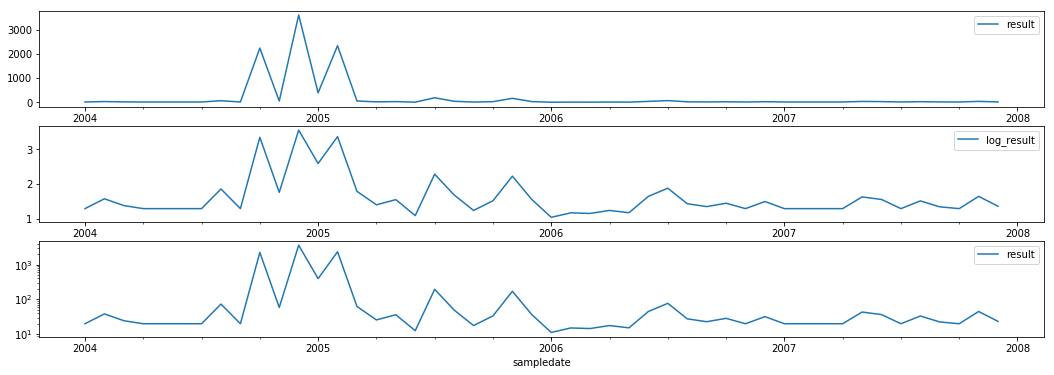

In [2]:
# The results has a large range, so log transformation makes them easier to visualize. These three plots show the original 
# result column, the column plotted with a log scale, and the column plotted with the data log transformed. 
# The really important part here is that the log trasform must be run after the resampling, because adding  values gets a 
# very different result from adding their logs

fig, ax = plt.subplots(3,figsize=(18,6))

_ = dfs[(dfs.stationcode=='IB-080') & (dfs.sampledate.dt.year > 2003) & (dfs.sampledate.dt.year < 2008)].set_index('sampledate').resample('1m').mean()

# Log transformation myst be applied after resampling. l
_['log_result'] = _.result.apply(np.log10)

_.plot(ax=ax[0], y='result')

ax[2].set_yscale("log", basey=10)
_.plot(ax=ax[2], y='result')

_.plot(ax=ax[1], y='log_result')

# Station group correlations

It is likely that since stations within a group are close to each other, the measures for one group are similar to others in the same group. So, we should try to characterize how well readings between stations in a group are correlated. 

The first way to examine correlations is usually to examine plots, so well create multiple plots, one for each station group to see if it looks like the results vary together.  


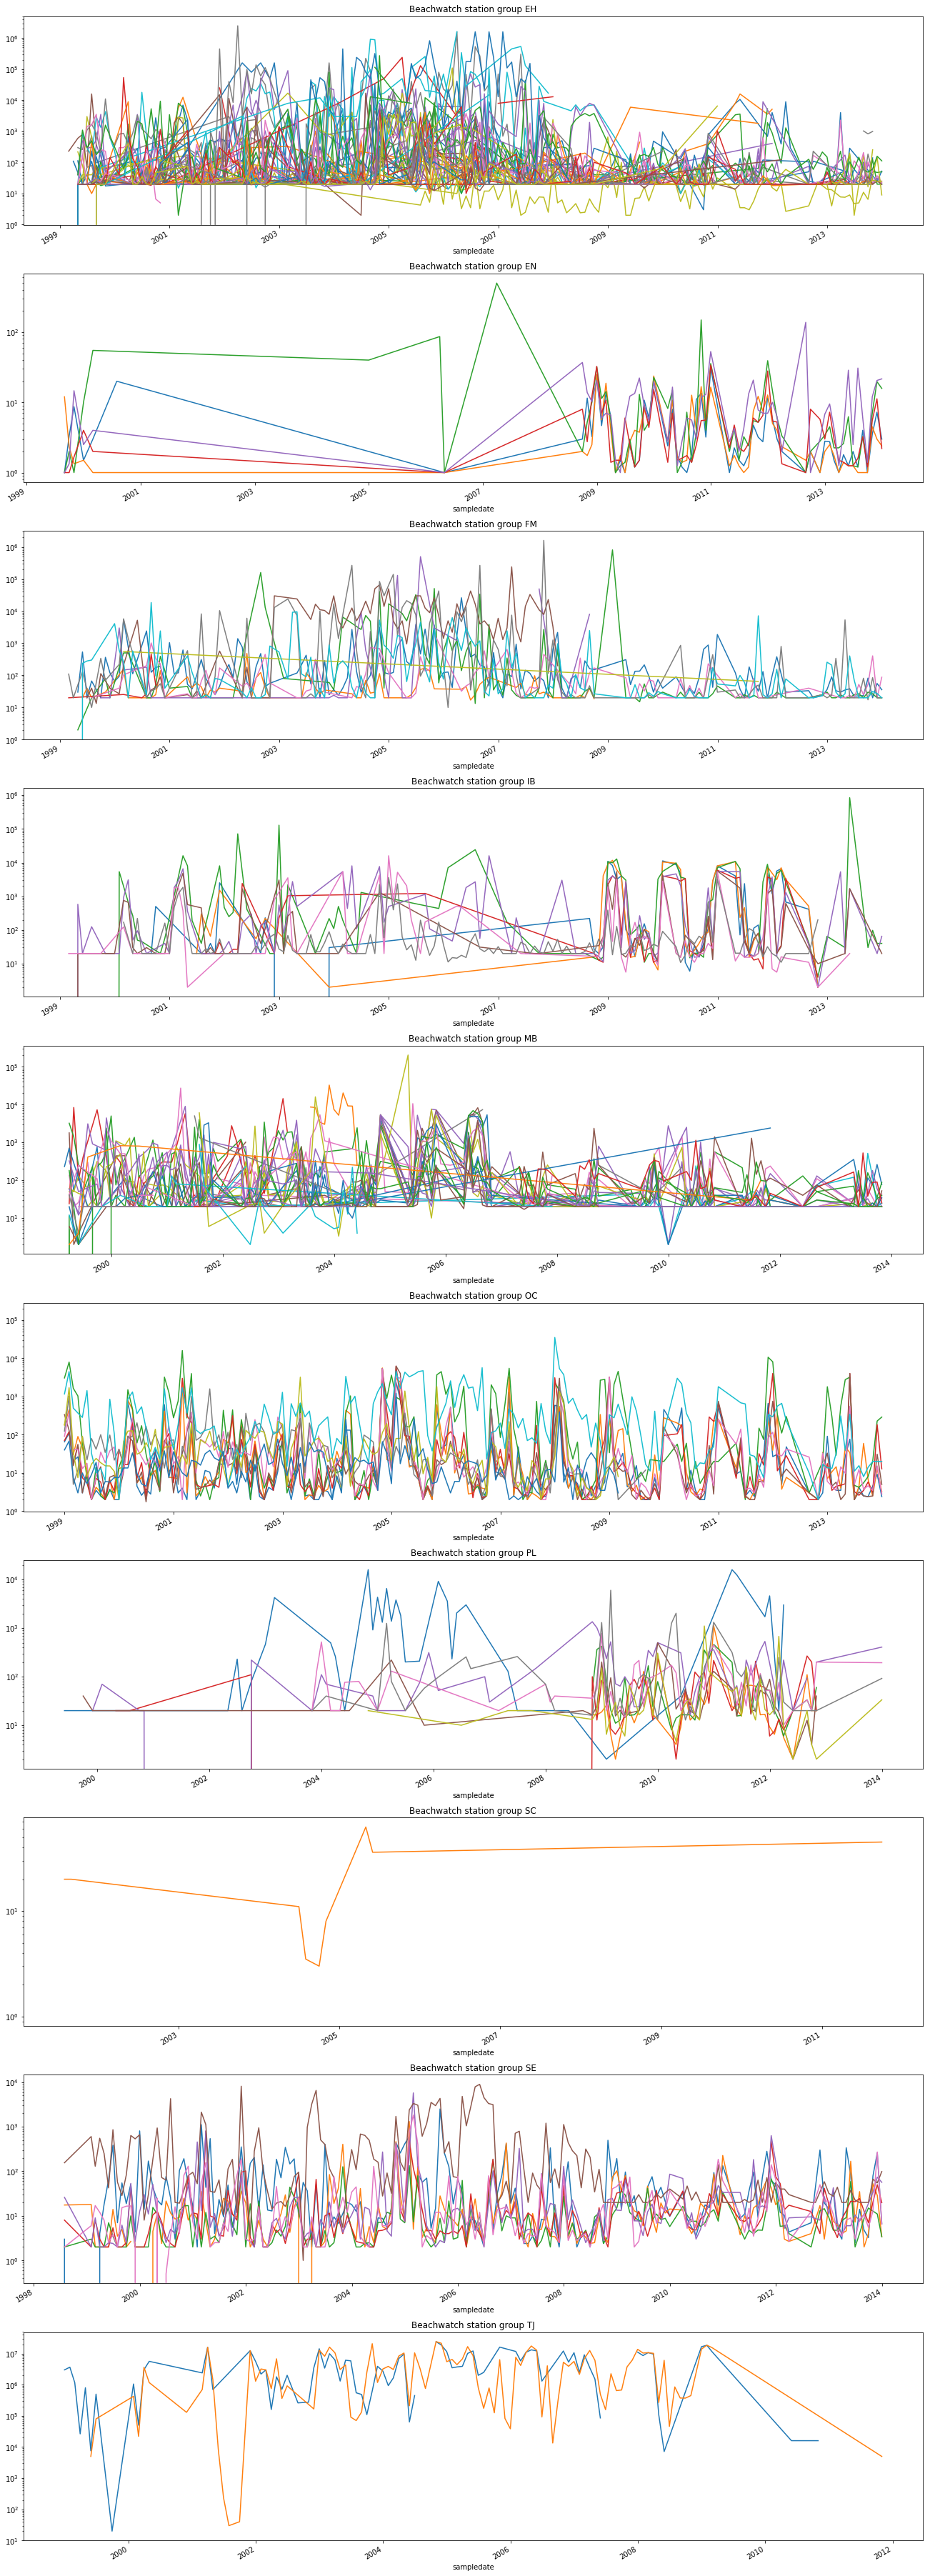

In [3]:
groups = list(dfs.stationgroup.unique())
fig, axes = plt.subplots(len(groups), 1,figsize=(18,5*len(groups)))

for ax, group in zip(axes, groups):
    
    _ = dfs[(dfs.stationgroup==group)]\
        .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()
    _['log_result'] = _.result.apply(np.log10)
    _.reset_index().set_index('sampledate').groupby('stationcode').plot(ax=ax,y='result', legend = False)
    ax.set_yscale("log", nonposy='clip')
    ax.set_title("Beachwatch station group {}".format(group))

    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    


## Mean Group Correlations and Pairwise Station Correlations 

In many cases, it looks stations within a group are correlated, although some look like they have less correlation than others. Next, we can try to do quantify the corelation. The Pandas ``.corr()``  method compute correlations for each pair of columns, returning a matrix. For a first attempt, we'll just take the mean of the pairwise correlations. 

In [4]:
from IPython.display import display

def mean_correlation(df, group, column='result'):
    """Build the corelation matrix for all columns, remove the diagonal, and average the remaining values. This uses
    the full matrix, not the triangular matrix, so each value appears twice. """
    
    _ = df[(df.stationgroup==group)]\
            .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()
    _['log_result'] = _.result.apply(np.log10)
    _ = _.reset_index().set_index(['stationcode','sampledate'])[column].unstack(level=0)
    corr = _.corr().stack().to_frame()
    corr.columns = [column]
    
    _ = corr[corr[column] < 1.0]

    
    return _.mean().iloc[0]


Should we try to correlate the results, or the log results? Let's try both.

In [5]:
pd.DataFrame([ (group, mean_correlation(df, group,'result') ) for group in groups ]).sort_values(1, ascending=False)
    

,0,1
7,SC,0.995537
9,TJ,0.843503
3,IB,0.492279
1,EN,0.387961
5,OC,0.327217
8,SE,0.286719
6,PL,0.246443
2,FM,0.125170
4,MB,0.109321
0,EH,0.036155


In [6]:
pd.DataFrame([ (group, mean_correlation(df, group,'log_result') ) for group in groups ]).sort_values(1, ascending=False)
   

,0,1
7,SC,0.813389
9,TJ,0.593167
1,EN,0.567652
3,IB,0.544057
5,OC,0.428767
8,SE,0.324201
6,PL,0.320919
2,FM,0.224064
4,MB,0.122401
0,EH,0.078083


I don' know that it's technical better, but the log results corelation are more like what we'd expect, with strong connections for EN and IB. TJ and SC have few readings on few datasets, so they should be ignored,  but the correlations on the others are stronger for the log results. 


In [7]:
def station_corr_matrix(df, group):
    _ = df[(df.stationgroup==group)].set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()[['result']]
    _.reset_index().set_index(['stationcode','sampledate'])['result']
    _['result'] = _.result.apply(np.log10)
    return _.unstack(level=0).corr()

def plot_stations_annotated(gdf, group, figsize=None):

    _ = gdf[gdf.stationgroup==group]

    if figsize:
        fig, ax = plt.subplots(1,figsize=figsize)
        _.plot(ax=ax)
    else:
        ax = _.plot()

    for x, y, label in zip(_.geometry.x, _.geometry.y, _.stationcode):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

result                                        
stationcode           EN-010    EN-020    EN-030    EN-040    EN-050
       stationcode                                                  
result EN-010       1.000000  0.708135  0.670475  0.692055  0.418737
       EN-020       0.708135  1.000000  0.574485  0.592271  0.327111
       EN-030       0.670475  0.574485  1.000000  0.628896  0.392701
       EN-040       0.692055  0.592271  0.628896  1.000000  0.386477
       EN-050       0.418737  0.327111  0.392701  0.386477  1.000000

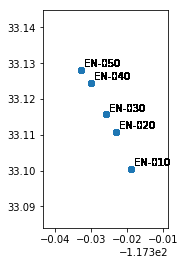

In [8]:

gdf = gpd.GeoDataFrame(dfs, geometry=
                        [Point(x,y) for x,y in zip(dfs.targetlongitude, dfs.targetlatitude)])



display(station_corr_matrix(dfs, 'EN'))
plot_stations_annotated(gdf, 'EN')

This is odd; There is a high correlation between ``EN-050`` and ``EN-040``, which is expected because they are next to each other, but ``EN-020`` has a slight negative correlation t0 ``EN-030``, which it is adacent to, but a positive correlation to ``EN-040`` which is farther away. 

result                                          \
stationcode           IB-010    IB-020    IB-030    IB-040    IB-050   
       stationcode                                                     
result IB-010       1.000000  0.908323  0.713853  0.619416  0.632462   
       IB-020       0.908323  1.000000  0.668886  0.660695  0.668446   
       IB-030       0.713853  0.668886  1.000000  0.673543  0.630493   
       IB-040       0.619416  0.660695  0.673543  1.000000  0.916039   
       IB-050       0.632462  0.668446  0.630493  0.916039  1.000000   
       IB-060       0.483203  0.560551  0.572791  0.707664  0.740594   
       IB-070       0.340613  0.394001  0.204478  0.425452  0.463144   
       IB-080       0.068110 -0.048785  0.015335  0.115044  0.297340   

                                                  
stationcode           IB-060    IB-070    IB-080  
       stationcode                                
result IB-010       0.483203  0.340613  0.068110  
       IB-020       0.560551  0.394001 -0.048785  
       IB-030       0.572791  0.204478  0.015335  
       IB-040       0.707664  0.425452  0.115044  
       IB-050       0.740594  0.463144  0.297340  
       IB-060       1.000000  0.635393  0.483520  
       IB-070       0.635393  1.000000  0.567900  
       IB-080       0.483520  0.567900  1.000000

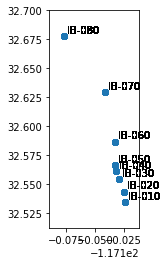

In [9]:
display(station_corr_matrix(dfs, 'IB'))
plot_stations_annotated(gdf, 'IB')

The IB correlations look more sensible. ``IB-070`` and ``IB-080`` have a strong correlation with each other, but not the rest, since they are farther away. The more southern stations are strongly correlated with each other. 

result                                                 \
stationcode           MB-010 MB-015    MB-020    MB-030    MB-031    MB-040   
       stationcode                                                            
result MB-010       1.000000    NaN -0.561518  0.004018  0.767503  0.695308   
       MB-015            NaN    NaN       NaN       NaN       NaN       NaN   
       MB-020      -0.561518    NaN  1.000000  0.228268 -1.000000 -0.209517   
       MB-030       0.004018    NaN  0.228268  1.000000  0.504232 -0.223738   
       MB-031       0.767503    NaN -1.000000  0.504232  1.000000  0.882730   

                                                             ...               \
stationcode          MB-041    MB-042    MB-050    MB-051    ...       MB-180   
       stationcode                                           ...                
result MB-010           NaN  1.000000  0.547545       NaN    ...     0.491376   
       MB-015           NaN       NaN       NaN       NaN    ...          NaN   
       MB-020           NaN       NaN  0.126848       NaN    ...    -0.572253   
       MB-030       1.00000 -0.280823  0.125154 -0.959313    ...     0.343409   
       MB-031       0.45685  0.772627  0.719230  0.318134    ...          NaN   

                                                                      \
stationcode           MB-190    MB-191    MB-192    MB-193    MB-200   
       stationcode                                                     
result MB-010       0.031599       NaN       NaN       NaN -1.000000   
       MB-015            NaN       NaN       NaN       NaN       NaN   
       MB-020      -1.000000       NaN       NaN       NaN       NaN   
       MB-030      -0.331696 -0.270650 -0.642381       NaN  0.813305   
       MB-031            NaN  0.176063  0.258657  0.643172  1.000000   

                                                            
stationcode           MB-203    MB-205    MB-223    MB-225  
       stationcode                                          
result MB-010       0.606820  0.371025  0.310419  0.753258  
       MB-015            NaN       NaN       NaN       NaN  
       MB-020            NaN       NaN       NaN       NaN  
       MB-030            NaN       NaN  0.061087 -0.364385  
       MB-031       0.429436 -0.282045  0.555228  0.585567  

[5 rows x 46 columns]

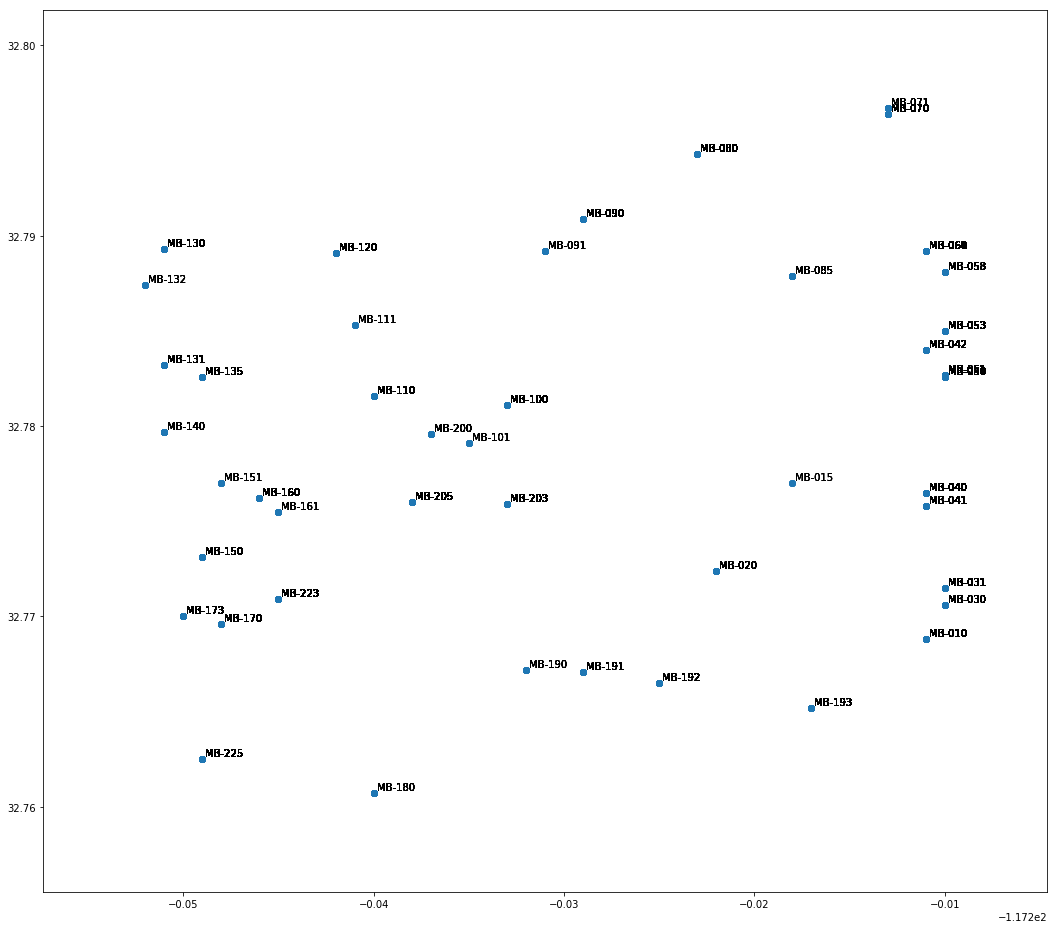

In [10]:
display(station_corr_matrix(dfs, 'MB').head())
plot_stations_annotated(gdf, 'MB', figsize=(18,18))

# More Correlations


Let's look at correlatios across all of the stations, using a different method. Here we will create a coorelation matrix of all stations, then remove all of the duplicates, using a sorting method, rather than the traditional method of using a triangular mask. Then we can plot the most correlated station pairs to see if they look right. 

In [11]:
# Pull out the MB stations because, while there are a lot of MB group readings, there 
# is a small number of them for each station
_ = dfs[~dfs.stationgroup.isin(['MB','SC'])][['stationcode','sampledate','result']]\
        .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='d')]).max()
_ = _.unstack(0)
_.columns  = _.columns.get_level_values(1)
bw_uns = _
bw_uns.head()

stationcode,EH-010,EH-020,EH-030,EH-033,EH-041,EH-050,EH-053,EH-056,EH-060,EH-062,...,PL-120,SE-010,SE-020,SE-030,SE-040,SE-050,SE-060,SE-070,TJ-020,TJ-030
sampledate,,,,,,,,,,,,,,,,,,,,,
1999-04-02,300.0,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1400000.0,NaN
1999-04-29,20.0,20.0,20.0,NaN,NaN,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-04-30,20.0,20.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-05-26,20.0,20.0,40.0,NaN,NaN,20.0,NaN,NaN,20.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-06-30,20.0,20.0,40.0,NaN,NaN,20.0,NaN,230.0,3000.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
bw_uns_l = np.log(bw_uns)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [13]:
def build_corr_ranks(df):
    _ = df.corr().stack().sort_values(ascending=False).to_frame()
    _.columns = ['result']
    _ = _[_.result< .99999]
    _.index.set_names(['sc1', 'sc2'], inplace=True)
    _.reset_index(inplace=True)

    # The correlation function is symmetric, so the dataframe has correlation values for (a,b) 
    # and for (b,a). We git rid of these by sording the station codes, then removing duplicates. 
    cond = _.sc1 > _.sc2
    _.loc[cond, ['sc1', 'sc2']] = _.loc[cond, ['sc2', 'sc1']].values
    _ = _.drop_duplicates()

    _ = _.copy()

    _['sg1'] = _.sc1.str[:2]
    _['sg2'] = _.sc2.str[:2]

    return _
    
corr_ranks = build_corr_ranks(bw_uns_l)
corr_ranks.head()

,sc1,sc2,result,sg1,sg2
0,EH-170,EH-255,0.996583,EH,EH
2,EH-010,EH-290,0.996317,EH,EH
4,EH-340,IB-070,0.995545,EH,IB
6,EH-290,FM-020,0.995249,EH,FM
8,EH-205,FM-060,0.991836,EH,FM


Here are the plots. Notice that in a lot of cases, there is a high corelation, but only on a small part of the range, because one station has a lot fewer measurements than the other. 

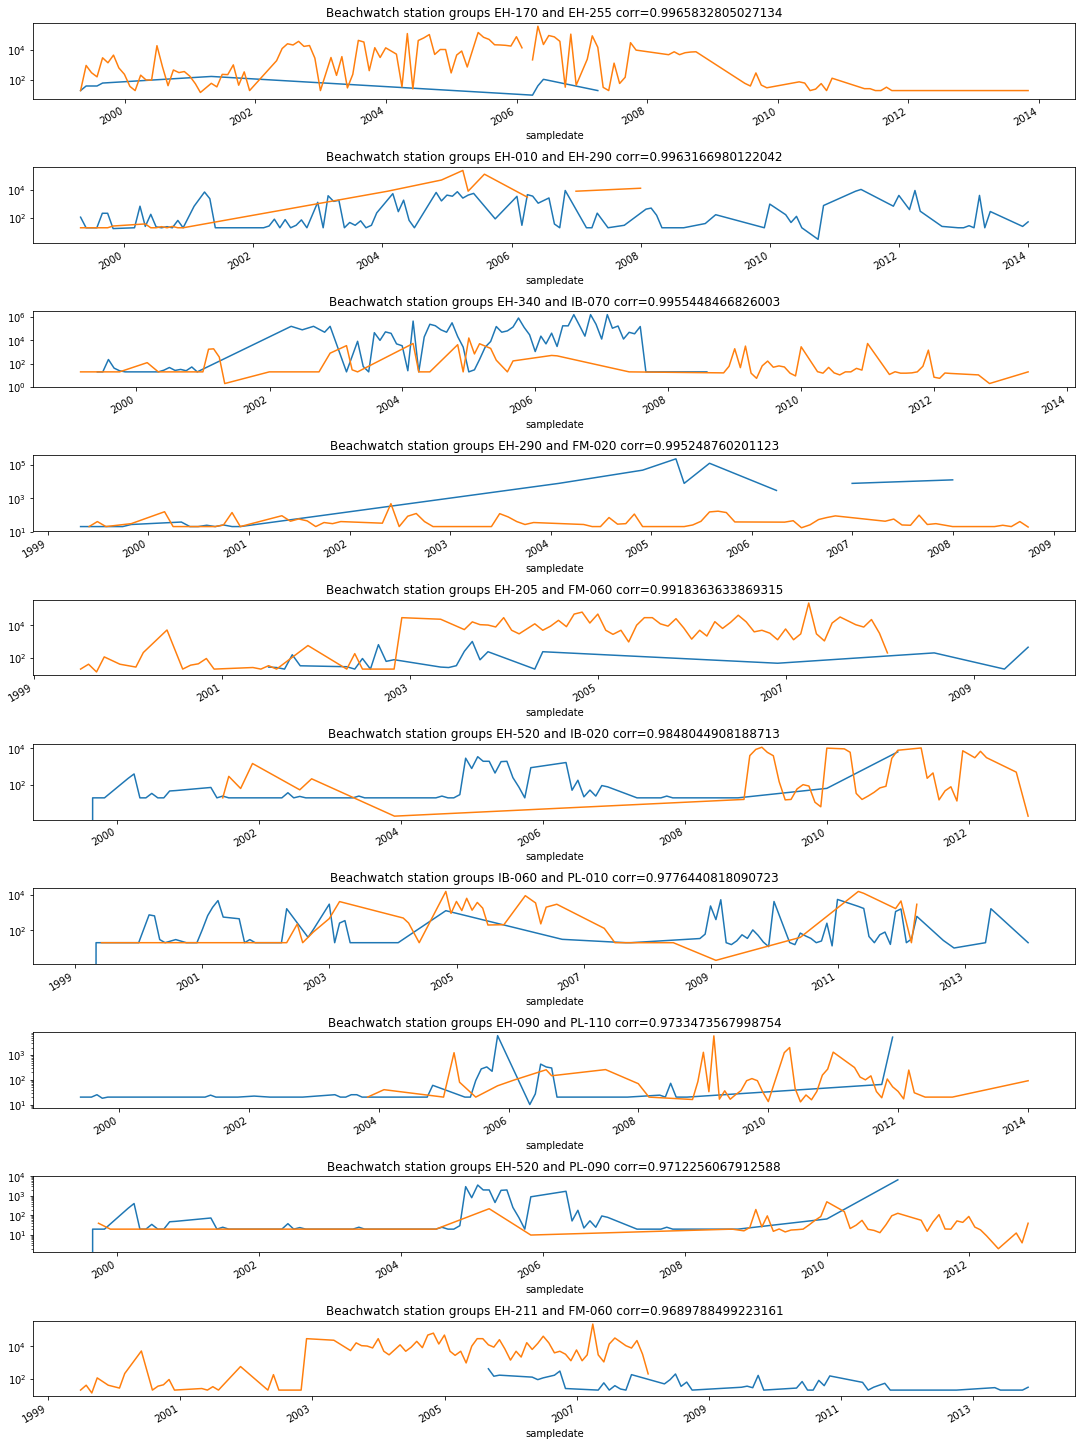

In [14]:
def plot_corr_pairs(df, corr):
    
    fig, axes = plt.subplots(len(corr),figsize=(15,2*len(corr)))

    for ax, (idx, r) in zip(axes,corr.iterrows()):

        _ = df[df.stationcode.isin([r.sc1,r.sc2])]\
               .set_index('sampledate').groupby(['stationcode',pd.Grouper(freq='m')]).mean()
        _['log_result'] = _.result.apply(np.log10)
        _.reset_index().set_index('sampledate').groupby('stationcode').plot(ax=ax,y='result', legend = False)
        ax.set_yscale("log", nonposy='clip')
        ax.set_title("Beachwatch station groups {} and {} corr={}".format(r.sc1, r.sc2, r.result))


    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    

plot_corr_pairs(dfs, corr_ranks.iloc[:10])

Look for correlations specifically among stations from different station groups. Most of these look spurious, but the correlations bewtween the IB and OC stations after 2009 look strong, which is very suspicious because they are the most distant two station groups. 

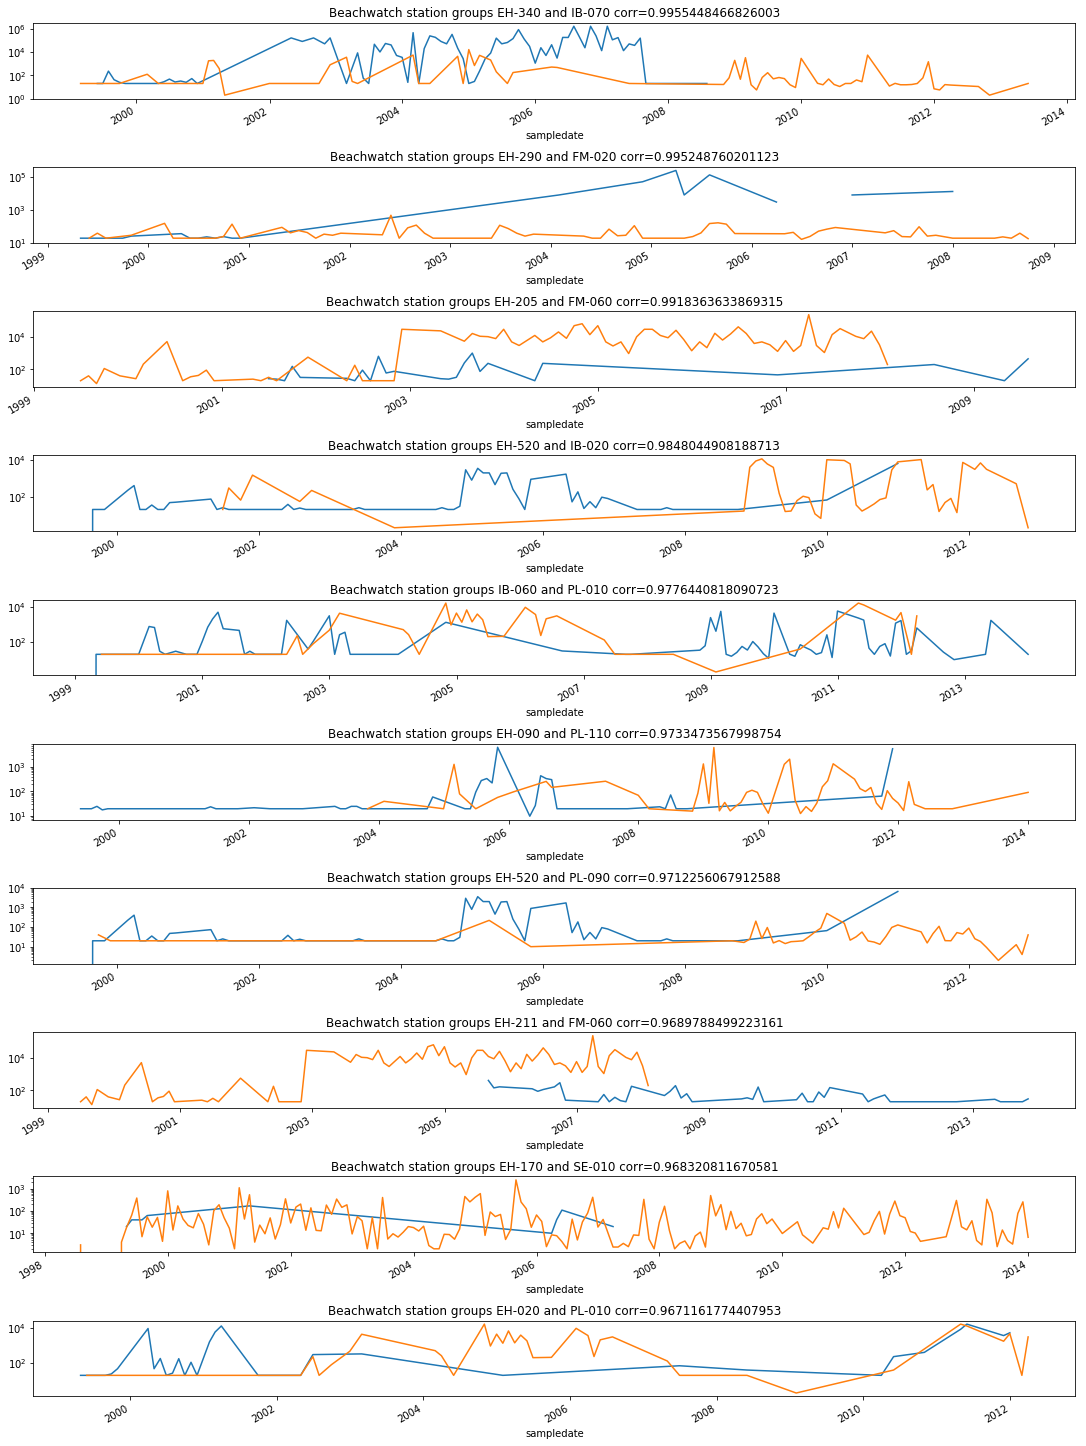

In [15]:
plot_corr_pairs(dfs, corr_ranks[corr_ranks.sg1 != corr_ranks.sg2 ].iloc[:10])

### Why are OC and IB Correlated?

The IB and OC stations, which are the farthest appart,  seem oddly correalted, after 2009. Below are plots of the top correlated stations. I suspect these are correlated because they are the stations that have the strongest seasonal variation; they are not actually correlated to each other, but are rather both correlated to the seasons. 

From that perspective, the interesting question is not why are these station groups correlated with each other, but why aren't all of the station groups correlated. 



In [16]:
corr_ranks_2009 = build_corr_ranks(bw_uns_l.loc['2009':])
ib_oc_09_cr = corr_ranks_2009[ (corr_ranks_2009.sg1.isin(['IB','OC'])) &  \
                               (corr_ranks_2009.sg2.isin(['IB','OC'])) &  \
                               (corr_ranks_2009.sg1 != corr_ranks_2009.sg2) ]
ib_oc_09_cr.iloc[:10]

,sc1,sc2,result,sg1,sg2
68,IB-020,OC-020,0.859978,IB,OC
72,IB-010,OC-020,0.857085,IB,OC
96,IB-020,OC-010,0.809331,IB,OC
104,IB-010,OC-010,0.800330,IB,OC
126,IB-020,OC-030,0.748849,IB,OC
132,IB-010,OC-030,0.746946,IB,OC
182,IB-030,OC-020,0.670576,IB,OC
204,IB-010,OC-040,0.655152,IB,OC
254,IB-020,OC-040,0.606516,IB,OC
258,IB-030,OC-010,0.602476,IB,OC


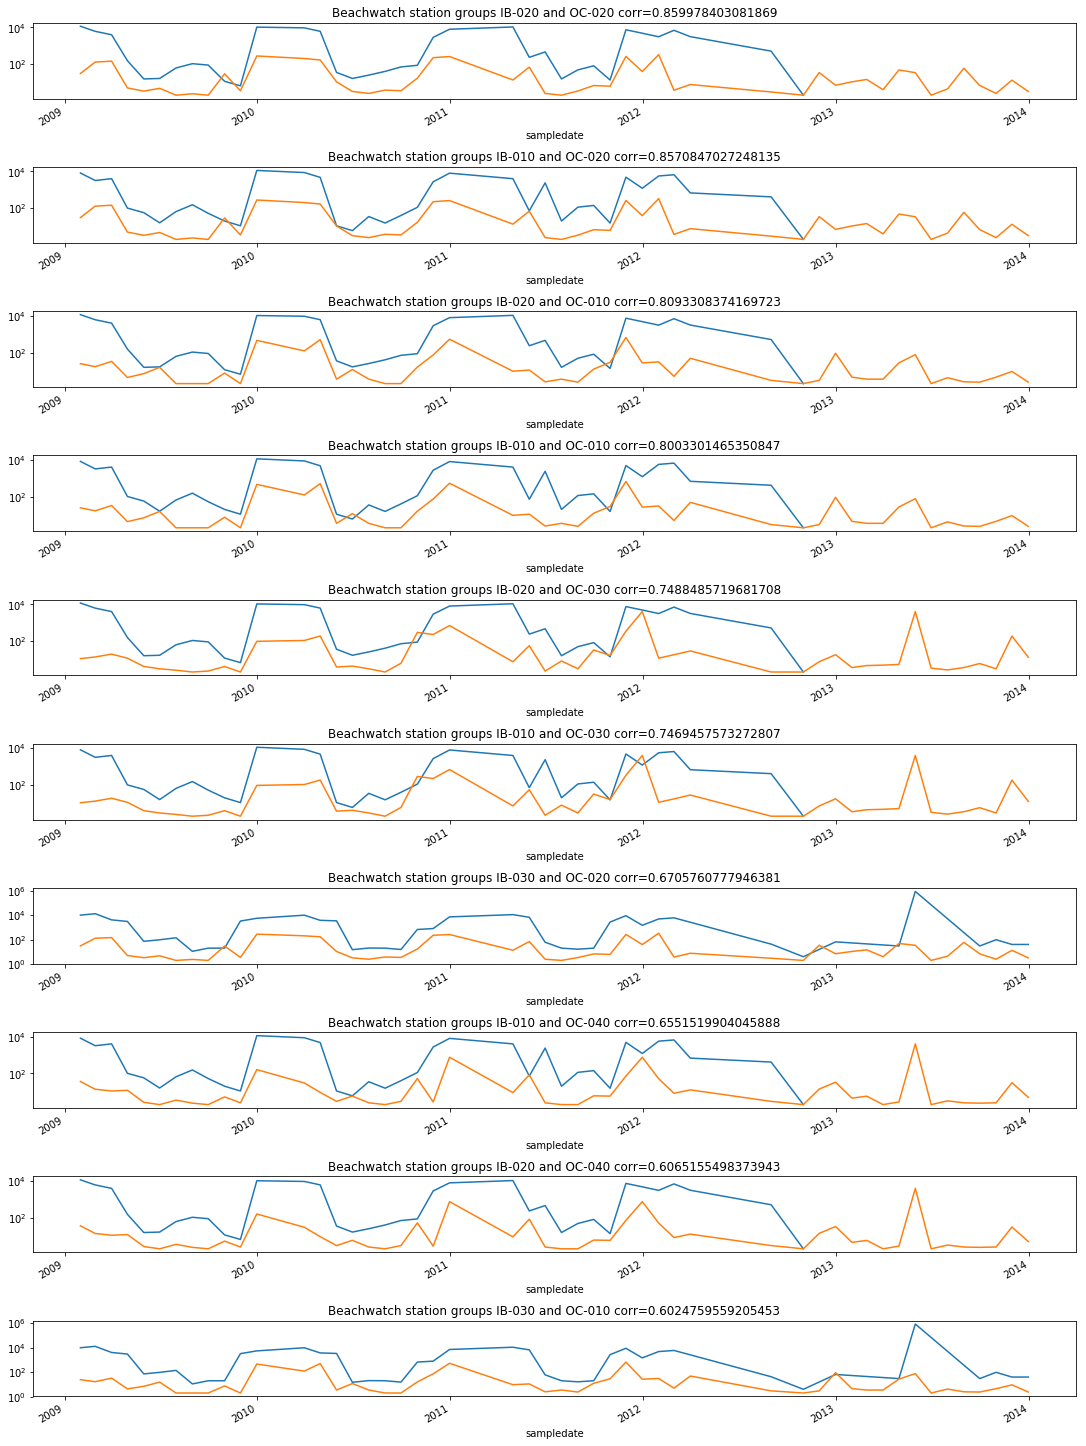

In [17]:
plot_corr_pairs(dfs[dfs.sampledate.dt.year >=2009], ib_oc_09_cr.iloc[:10])

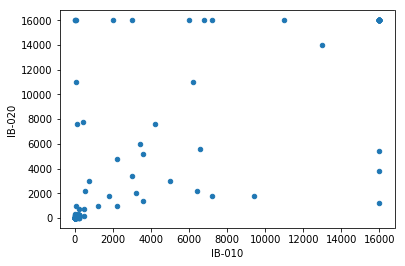

In [18]:
bw_uns[['IB-010','IB-020']].dropna().plot(kind='scatter', x='IB-010',y='IB-020')

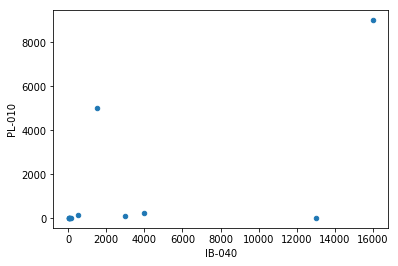

In [19]:
bw_uns[['IB-040','PL-010']].dropna().plot(kind='scatter', x='IB-040',y='PL-010')

# Next Steps

This analysis provides some guidance for future analysis. Conclusions include: 

- We should probably analyze log results, rather than just results. 
- Stations that are close to each other are likely to have correlated results. We might be able to create composite measurements from groups of stations. 

Questions we should answer with addtional analysis: 

- What watersheds are the station groups in? Are all stations in one group in the same watershed?
- What creeks are the stations near?
- How do results correlate to rainfall?
- How do results correlate to creek flow. 

In [20]:

dfg = df[['stationcode','analyte','unit','result','sampledate']]
dfg.head()

,stationcode,analyte,unit,result,sampledate
0,EH-010,"Coliform, Total",MPN/100 mL,300.0,1999-04-02
1,EH-010,"Coliform, Total",MPN/100 mL,20.0,1999-04-29
2,EH-010,"Coliform, Total",MPN/100 mL,20.0,1999-04-30
3,EH-010,Enterococcus,MPN/100 mL,10.0,1999-05-26
4,EH-010,"Coliform, Fecal",MPN/100 mL,20.0,1999-05-26


In [21]:
#df[df.stationcode=='EH-010'].set_index('sampledate')[['analyte','result']].groupby('sampledate').count().analyte.sort_values(ascending=False)
df[df.stationcode=='EH-010'].set_index('sampledate').loc['2004-05-02'][['analyte','result']].sort_values('analyte')

,analyte,result
sampledate,,
2004-05-02,"Coliform, Fecal",70.0
2004-05-02,"Coliform, Fecal",110.0
2004-05-02,"Coliform, Fecal",130.0
2004-05-02,"Coliform, Total",170.0
2004-05-02,"Coliform, Total",130.0
2004-05-02,"Coliform, Total",140.0
2004-05-02,Enterococcus,10.0
2004-05-02,Enterococcus,20.0


In [22]:
df.set_index('sampledate')[['stationcode','analyte','result']].groupby(['stationcode','analyte','sampledate']).count().sort_values('result', ascending=False)

result
stationcode analyte         sampledate        
FM-010      Coliform, Total 2006-04-24      16
EH-480      Coliform, Total 2007-04-03      16
FM-010      Coliform, Fecal 2006-04-24      14
            Enterococcus    2006-04-24      12
EH-480      Coliform, Fecal 2007-04-03      11
FM-010      Coliform, Fecal 2006-04-26      11
EH-480      Coliform, Total 2007-04-02      11
FM-010      Coliform, Total 2005-11-16      10
            Coliform, Fecal 2006-04-25      10
FM-100      Coliform, Total 2003-03-20      10
FM-010      Coliform, Total 2006-04-26      10
            Enterococcus    2005-08-10      10
                            2005-11-15       9
EH-480      Coliform, Fecal 2007-04-02       9
SE-060      Coliform, Total 2003-04-14       9
FM-010      Coliform, Total 2005-04-20       9
            Coliform, Fecal 2005-03-11       9
            Coliform, Total 2005-08-10       9
FM-100      Coliform, Fecal 2003-08-07       9
FM-010      Coliform, Fecal 2005-11-14       9
                            2006-04-27       9
            Enterococcus    2006-04-26       9
            Coliform, Fecal 2005-11-15       9
SE-060      Coliform, Fecal 2003-04-14       9
FM-010      Coliform, Fecal 2005-04-20       9
            Enterococcus    2005-08-18       9
                            2005-08-11       9
FM-100      Enterococcus    2003-04-17       9
FM-010      Coliform, Fecal 2005-08-11       9
FM-100      Coliform, Total 2003-04-18       9
...                                        ...
OC-100      Coliform, Fecal 2006-05-07       0
IB-080      Coliform, Fecal 2006-08-14       0
OC-100      Coliform, Fecal 2006-05-05       0
                            2006-04-25       0
                            2006-04-21       0
                            2006-04-14       0
                            2006-04-06       0
IB-030      Coliform, Fecal 2011-12-15       0
OC-100      Coliform, Fecal 2006-03-15       0
IB-080      Coliform, Fecal 2006-08-17       0
                            2006-08-10       0
                            2006-06-19       0
                            2006-07-10       0
OC-100      Coliform, Fecal 2006-06-22       0
IB-080      Coliform, Fecal 2006-06-22       0
                            2006-06-26       0
IB-050      Coliform, Fecal 2011-12-17       0
IB-080      Coliform, Fecal 2006-06-29       0
                            2006-07-03       0
                            2006-07-06       0
OC-100      Coliform, Fecal 2006-06-16       0
                            2006-06-01       0
IB-080      Coliform, Fecal 2006-07-13       0
                            2006-07-17       0
                            2006-07-20       0
OC-100      Coliform, Fecal 2006-06-09       0
IB-080      Coliform, Fecal 2006-07-27       0
                            2006-08-03       0
                            2006-08-07       0
MB-040      Coliform, Fecal 2006-08-08       0

[192485 rows x 1 columns]